In [1]:
import numpy as np
import matplotlib.pyplot as plt  # Just so we can visually confirm we have the same images
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.utils#.data.Dataset
import glob
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore', '.*output shape of zoom.*')

from random import shuffle

from torch.optim.lr_scheduler import StepLR

from random import shuffle
from numpy import percentile

import random
import cv2

from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
from torchvision import transforms
import torchvision.transforms.functional as TF
gpu_number = "0"            

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_number

# from adabound import AdaBound

In [2]:
i=plt.imread('/home/Drive3/rahul/nucli-seg/All_30/TCGA-E2-A14V-01Z-00-DX1.tif')
n=np.load('/home/Drive3/rahul/nucli-seg/All_30P/a22.npy')
n2=np.load('/home/Drive3/rahul/nucli-seg/GTP/a22.npy')

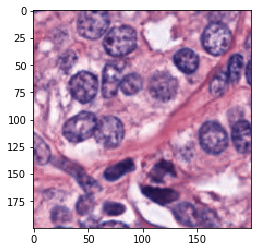

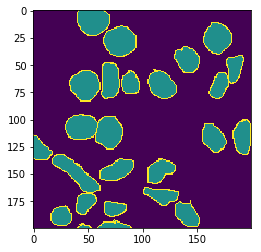

In [3]:
plt.imshow(n); plt.show();plt.imshow(n2); plt.show()

In [5]:
tra=glob.glob('/home/Drive3/rahul/nucli-seg/All_30P/*')
msk_list=glob.glob('/home/Drive3/rahul/nucli-seg/GTP/*')
len(tra),len(msk_list)

(775, 775)

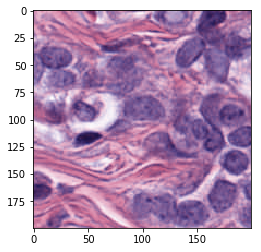

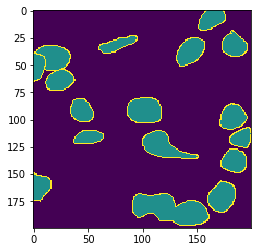

In [7]:
name=tra[10].split('/')[-1].split('.')[-2]
j=np.load('/home/Drive3/rahul/nucli-seg/GTP/'+name+'.npy')

plt.imshow(np.load(tra[10]));plt.show()
plt.imshow(j);plt.show()

In [8]:

r1=np.load('nucli-list.npy') # saved lists for reproducibility
r2=np.load('nucli-list2.npy')

In [10]:
#All surface loss functions
from scipy.ndimage import distance_transform_edt as distance
from torch import einsum
def uniq(a):
    return set(torch.unique(a.cpu()).numpy())
def sset(a, sub):
    return uniq(a).issubset(sub)
def one_hot(t, axis=1) :
    return simplex(t, axis) and sset(t, [0, 1])
def class2one_hot(seg, C) :
    if len(seg.shape) == 2:  # Only w, h, used by the dataloader
        seg = seg.unsqueeze(dim=0)
    assert sset(seg, list(range(C)))
    b, w, h = seg.shape  # type: Tuple[int, int, int]
    res = torch.stack([seg == c for c in range(C)], dim=1).type(torch.int32)
    assert res.shape == (b, C, w, h)
#     assert one_hot(res)
    return res
def simplex(t, axis=1):
    _sum = t.sum(axis).type(torch.float32)
    _ones = torch.ones_like(_sum, dtype=torch.float32)
    return torch.allclose(_sum, _ones)
def one_hot2dist(seg) :
    assert one_hot(torch.Tensor(seg), axis=0)
    C= len(seg)
    res = np.zeros_like(seg)
    for c in range(C):
        posmask = seg[c].astype(np.bool)
        if posmask.any():
            negmask = ~posmask
            res[c] = distance(negmask) * negmask - (distance(posmask) - 1) * posmask
    return res
class SurfaceLoss():
    def __init__(self, **kwargs):
        # Self.idc is used to filter out some classes of the target mask. Use fancy indexing
        self.idc= kwargs["idc"]
        print(self.__class__.__name__,kwargs)

    def __call__(self, probs, dist_maps, _) :
        assert simplex(probs)
        assert not one_hot(dist_maps)

        pc = probs[:, self.idc, ...].type(torch.float32)
        dc = dist_maps[:, self.idc, ...].type(torch.float32)

        multipled = einsum("bcwh,bcwh->bcwh", pc, dc)

        loss = multipled.mean()

        return loss

In [11]:
def one_hot_my(a): # one hot encoder for seg masks
    g1=a[:,:]==0
    g2=a[:,:]==1
    return torch.stack((g1,g2),0)
class NDataset(Dataset):
    # Data set of patches
    def __init__(self,mode,r1=r1,r2=r2,transform=False):
        self.im_list=glob.glob('/home/Drive3/rahul/nucli-seg/All_30P/*')
        if mode=='train':
            self.im_list=list(np.array(self.im_list)[r1])
        else:
            self.im_list=list(np.array(self.im_list)[r2])
        self.transform = transform
        
    def __len__(self):
        return len(self.im_list)
    
    def __getitem__(self, idx,h=None,w=None):
        small_flag = 0
        
        image=np.load(self.im_list[idx])
        name=self.im_list[idx].split('/')[-1].split('.')[-2]
        mask=np.load('/home/Drive3/rahul/nucli-seg/GTP/'+name+'.npy') 

        image = image - 160.55218800
        image = image / (52.90401397559)

        groundTruth = mask 
        groundTruth = torch.from_numpy(groundTruth).float()#.unsqueeze(0)
        groundTruth[groundTruth==0.49803922]=1

        if self.transform:
            
            to_pil = transforms.ToPILImage()
            to_ten = transforms.ToTensor()
            if random.random() >0.5:
                image = to_ten(TF.hflip(to_pil(image)))
                groundTruth = to_ten(TF.hflip(to_pil(groundTruth)))
            deg = random.randint(-90, 90)
            image = to_ten(TF.rotate(to_pil(image),deg))
            groundTruth = to_ten(TF.rotate(to_pil(groundTruth),deg))
        seg=one_hot_my(groundTruth) 
        
        h,w=200,200
        mask_tensor = torch.tensor(groundTruth, dtype=torch.int64)  ###################################
        mask_onehot = class2one_hot(mask_tensor, 2)[0]  # because the res is bchw
        mask_distmap = one_hot2dist(mask_onehot.cpu().numpy())
            
        sample = {'image': torch.tensor(image).transpose(2,1).transpose(0,1), 'mask':seg,'mask2': groundTruth,  'mask_distmap': torch.tensor(mask_distmap).float(),'name':name }
        return sample
class EvalDataset(Dataset):
        # DS of whole images
        # This dataset got messed up in validation as it was somehow generating the same two random numbers and feeding in the same two images for vals
        # so the random numbers were taken onside: see only_validator()
    def __init__(self,mode,transform=False):
        self.im_list=glob.glob('/home/Drive3/rahul/nucli-seg/All_30/*')
        if mode=='train':
            self.im_list=self.im_list[:-2]
        else:
            self.im_list=self.im_list[-2:]
        self.transform = transform
        
    def __len__(self):
        return len(self.im_list)
    
    def __getitem__(self, idx):
        small_flag = 0
        
        image=cv2.imread(self.im_list[idx],0)
        name=self.im_list[idx][36:-4]
        mask=plt.imread('/home/Drive3/rahul/nucli-seg/GT/'+name+'.png') 
        
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        image = clahe.apply(image)
        image = torch.from_numpy(image).float().unsqueeze(0)
        image = image/255
        
        groundTruth = mask 
        groundTruth = torch.from_numpy(groundTruth).float()#.unsqueeze(0)
        groundTruth[groundTruth==0.49803922]=1

        image=image#[:,h:h+192,w:w+192]
        groundTruth=groundTruth#[h:h+192,w:w+192]
        if self.transform:
            
            to_pil = transforms.ToPILImage()
            to_ten = transforms.ToTensor()
            if random.random() >0.5:
                image = to_ten(TF.hflip(to_pil(image)))
                groundTruth = to_ten(TF.hflip(to_pil(groundTruth)))
            
            deg = random.randint(-90, 90)
            image = to_ten(TF.rotate(to_pil(image),deg))
            groundTruth = to_ten(TF.rotate(to_pil(groundTruth),deg))

        seg=one_hot_my(groundTruth) 
        sample = {'image': image, 'mask':seg,'mask2': groundTruth,  'small_flag': small_flag,'name':name }
        return sample


In [12]:
ds=NDataset('val')

In [13]:
a=iter(ds)

In [14]:
d=next(a)
np.shape(d['image']),np.shape(d['mask_distmap'])

/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


(torch.Size([3, 200, 200]), torch.Size([2, 200, 200]))

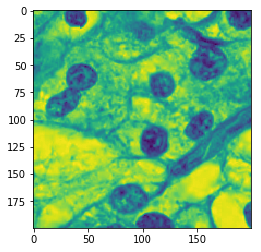

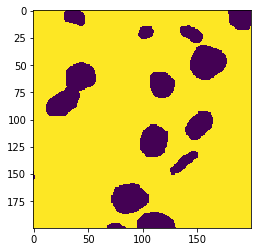

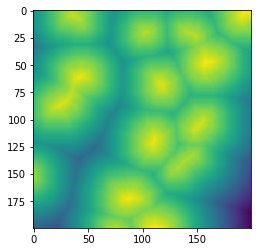

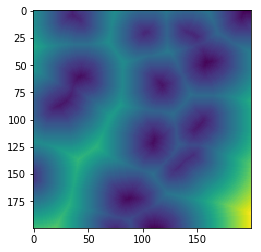

In [15]:
plt.imshow(d['image'][2]);plt.show()
plt.imshow(d['mask'][0]); plt.show()
plt.imshow(d['mask_distmap'][0]); plt.show()
plt.imshow(d['mask_distmap'][1]); plt.show()

In [16]:
import torch.nn.functional as F
class double_conv(torch.nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_ch, out_ch, 3, padding=1),
            torch.nn.BatchNorm2d(out_ch),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_ch, out_ch, 3, padding=1),
            torch.nn.BatchNorm2d(out_ch),
            torch.nn.ReLU(inplace=True)
        )
    def forward(self, x):
        x = self.conv(x)
        return x
class inconv(torch.nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x
class down(torch.nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = torch.nn.Sequential(
            torch.nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )
    def forward(self, x):
        x = self.mpconv(x)
        return x

class up(torch.nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()
        if bilinear:
            self.up = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = torch.nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        self.conv = double_conv(in_ch, out_ch)
        self.conv2=double_conv(1280,out_ch)
        self.up2=torch.nn.ConvTranspose2d(1024, in_ch//2, 2, stride=2)
    def forward(self, x1, x2):
        try:x1 = self.up(x1)
        except: x1 = self.up2(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        x = torch.cat([x2, x1], dim=1)
#         print(x.size())
        try:x = self.conv(x)
        except: x=self.conv2(x)
        return x
class outconv(torch.nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = torch.nn.Conv2d(in_ch, out_ch, 1)
    def forward(self, x):
        x = self.conv(x)
        return x

In [17]:
n_classes=2
class UNet(torch.nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.down4hard = down(512, 512)
        
        self.up1 = up(1536, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        xhard=self.down4hard(x4)
        
        
        x = self.up1(torch.cat((x5,xhard),1),x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [18]:


def dice_loss_classes(inpu, target):  # [bs,4,96,96,64]

    ip=inpu[:,0,:,:].contiguous().view(-1)
    tar=target[:,0,:,:].contiguous().view(-1)
    intersection=(ip * tar).sum() 
    union= ip.sum() + tar.sum()
    score1=1-2*(intersection/union)
    

    ip=inpu[:,1,:,:].contiguous().view(-1)
    tar=target[:,1,:,:].contiguous().view(-1)
    intersection=(ip * tar).sum() 
    union= ip.sum() + tar.sum()
    score2=1-2*(intersection/union)
     
    
    return score1,score2


In [19]:
# A bunch of useful funtions to get informative stats on output scores


def loss_to_score(my_dict): # converts dice loss to scores (1-loss)
    for e in my_dict.keys():
        for i in range(len(my_dict[e])):
            my_dict[e][i]=1-my_dict[e][i]
    return(my_dict)


def val_stats(my_dict,threshold=0.8,compare=None):
#     my_dict=loss_to_score(my_dict)
    l=[]
    eps=1
    
    for e in my_dict.keys():
        for i in range(len(my_dict[e])):
            l.append(my_dict[e][i])
#     print(l)       
    print('Global Mean: ', sum(l)/len(l))
    print('Global Std: ', np.std(np.array(l)))
    g=[]
    for e in my_dict.keys():
        for i in range(len(my_dict[e])):
            if my_dict[e][i]>threshold:
                g.append(my_dict[e][i])
    c=0
    for i in range(eps):
        
        print('Epoch: ',i-1, 'with ',c,'below')
        c=0
        for e in my_dict.keys():
            if my_dict[e][i]<=threshold:
                c+=1
            
    clip={}
    counter=0
    for e in my_dict.keys():
        for i in range(len(my_dict[e])):
            if my_dict[e][i]<=threshold:
                counter+=1
                
                if e not in clip.keys():clip[e]=[my_dict[e][i]]
                else:clip[e].append(my_dict[e][i])
            
    try:print('Clipped Mean: ', sum(g)/len(g))
    except: pass
    print('Number clipped: ', counter, 'of total ', len(l))
    
    print('Suspects: ')
    
    suspect_dict={}
    for e in clip.keys():
        suspect_dict[e]=my_dict[e]
        print(e,clip[e])
        
    data=np.array(l)
    quartiles = percentile(data, [25, 50, 75])
    # calculate min/max
    data_min, data_max = data.min(), data.max()
    # print 5-number summary
    print('--')
    print('--')
    print('Min: %.3f' % data_min)
    print('Q1: %.3f' % quartiles[0])
    print('Median: %.3f' % quartiles[1])
    print('Q3: %.3f' % quartiles[2])
    print('Max: %.3f' % data_max)
    
#     plt.plot(sorted(l))
#     plt.show()
    plt.hist(l)#,bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]*0.05)
    plt.title("histogram") 
    plt.show()
    
    if compare:
        print('Deltas')
        for e in my_dict.keys():
            print(e,' : ', sum(compare[e])/len(compare[e])-sum(my_dict[e]/len(my_dict[e])))
    return(suspect_dict)
    
def tta(my_dict):
    tta=[]
    for e in my_dict.keys():
        print(e,': ', sum(my_dict[e])/len(my_dict[e]), min(my_dict[e]), max(my_dict[e]))
        tta.append(sum(my_dict[e])/len(my_dict[e]))
    print('--')
    
    print('TTA Avg: ',sum(tta)/len(tta))    
    
def make_a(my_dict): # makes a dict on only class 0 dice scores from dict with [class 0, class 1]
    dicta={}
    for e in my_dict.keys():
        dicta[e]=[my_dict[e][0]][0] # takes first elemtn !
    return(dicta)
def make_b(my_dict):# makes a dict on only class 1 dice scores 
    dicta={}
    for e in my_dict.keys():
        dicta[e]=[my_dict[e][1]][0]
    return(dicta)       
        
def diff_checker(big1,big2):
    # Takes in hotlist and biglist of two trains
    # gets all culprits in both sets and returns a comparsion of those
    # biglist needed as some items only in one hotlist

    suspect_dict={}
    for e in big1.keys():
            s1=big1[e][1][0]
            s2=big2[e][1][0]
            diff=s1-s2
            print(e,' : ', diff) # avg across all vals(in case of TTA)
            suspect_dict[e]=[s1,s2,diff]
    return(suspect_dict)

def diff_checker2(big1,big2):
    # Takes in   biglist of single dice vals

    suspect_dict={}
    for e in big1.keys():
            s1=big1[e][0]
            s2=big2[e][0]
            diff=s1-s2
            print(e,' : ', diff) # avg across all vals(in case of TTA)
            suspect_dict[e]=[s1,s2,diff]
    return(suspect_dict)
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n   

# Baseline Train

In [20]:

model=UNet(3,2).cuda()
batch_size=6;batch_size_val=6

    
dataset = NDataset('train')
dataset_val=NDataset('val')    #val
data_loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2)
val_loader=DataLoader(dataset_val,batch_size_val,shuffle=True, num_workers=2) 
loaders={'train':data_loader,'val': val_loader}

In [21]:
loss_fn = torch.nn.CrossEntropyLoss()  
soft_max=torch.nn.Softmax(dim=1)
init_lr=0.001


opt = torch.optim.Adam(model.parameters(), lr=init_lr)


In [22]:
surface_loss = SurfaceLoss(idc=[1])  # **


('SurfaceLoss', {'idc': [1]})


In [26]:
def trainer(model,epochs,alpha,tamper,loaders=None,opt=opt):
    if not alpha: alpha= 0.99                               #******************************
    global my_dict,my_dict_val,L,Lc,Ldc,L_r,Lv,Lvc,Lvdc,Lsur
    if loaders==None:
        data_loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2)
        val_loader=DataLoader(dataset_val,batch_size_val,shuffle=True, num_workers=2) 
        loaders={'train':data_loader,'val': val_loader}
    for epoch in range(epochs):
        for e in loaders:
            if e=='train':  model.train() ; grad=True  
            else: model.eval() ; grad=False
            with torch.set_grad_enabled(grad):    
                for idx, batch_data in enumerate(loaders[e]):

                    name=batch_data['name']
                    input = Variable(batch_data['image'].float()).cuda()
                    dice_mask = Variable(batch_data['mask'].float()).cuda()
                    ce_tar=Variable(batch_data['mask2']).cuda()
                    dist_maps=Variable(batch_data['mask_distmap']).cuda() #*****************************
                    pred_mask = model(input)
                    ce = loss_fn(pred_mask, ce_tar.long())
                    soft_mask=soft_max(pred_mask)
                    a,b=dice_loss_classes(soft_mask, dice_mask)
                    
                    print(soft_mask.shape,dist_maps.shape)
                    new_loss=surface_loss(soft_mask, dist_maps, None) # ****************
                    loss = (alpha)*(a+b)/2 +(1-alpha)*new_loss #* ****************************
                    if tamper and alpha>0: alpha=alpha-tamper  # ******************************
                    if e=='train':
                        for names in name:
                            if names not in my_dict.keys(): my_dict[names]=[[1-a.item()],[1-b.item()]]
                            else: my_dict[names][0].append(1-a.item()); my_dict[names][1].append(1-b.item())
                        Lc=np.concatenate((np.array([ce.item()]), Lc)); cross_moving_avg=np.mean(Lc)
                        Ldc=np.concatenate((np.array([b.item()]), Ldc)); dice1=np.mean(Ldc)
                        L_r=np.concatenate((np.array([a.item()]), L_r)); dice0=np.mean(L_r)
                        L=np.concatenate((np.array([loss.item()]), L)); loss_moving_avg=np.mean(L)
                        Lsur=np.concatenate((np.array([new_loss.item()]), Lsur)); sur=np.mean(Lsur) #***********
                        print('Epo: ', epoch+1, ' Btch: ',idx+1,' Dce0: ', round(dice0,3),' Dce1: ', round(dice1,3), ' Sur: ',round(sur,3),' Loss :' ,round(loss_moving_avg,3))
                        loss.backward()
                        opt.step()
                        opt.zero_grad()
                    else:
                        for names in name:
                            if names not in my_dict_val.keys(): my_dict_val[names]=[[1-a.item()],[1-b.item()]]
                            else: my_dict_val[names][0].append(1-a.item()); my_dict_val[names][1].append(1-b.item())
                        print('Val Dice0', round(a.item(),3),' Dice1: ', round(b.item(),3), ' CE: ',round(ce.item(),3),' Loss :' ,round(loss_moving_avg,6) )
                        Lv=np.concatenate((np.array([loss.item()]), Lv)) ; lv_avg=np.mean(Lv)
                        Lvc=np.concatenate((np.array([ce.item()]), Lvc)) ;lvc_avg=np.mean(Lvc)
                        Lvdc=np.concatenate((np.array([b.item()]), Lvdc))
def valider(model,epochs=3,loaders_eval=None,opt=opt):
    if loaders_eval==None:
        data_eval = DataLoader(dataset, 1, shuffle=True, num_workers=2)
        val_eval=DataLoader(dataset_val,1,shuffle=True, num_workers=2) 
        loaders_eval={'val': val_eval,'train':data_eval}
    epochs=epochs
    global my_dict,my_dict_val,L,Lc,Ldc,L_r,Lv,Lvc,Lvdc
    for epoch in range(epochs):
        for e in loaders_eval:
            if e=='train':  model.train() ; grad=True  
            else: model.eval() ; grad=False
            with torch.set_grad_enabled(grad):    
                for idx, batch_data in enumerate(loaders_eval[e]):
                    name=batch_data['name']
                    input = Variable(batch_data['image'].float()).cuda()#.to(device)
                    dice_mask = Variable(batch_data['mask'].float()).cuda()
                    ce_tar=Variable(batch_data['mask2']).cuda()
                    pred_mask = model(input)
                    ce = loss_fn(pred_mask, ce_tar.long())
                    soft_mask=soft_max(pred_mask)
                    a,b=dice_loss_classes(soft_mask, dice_mask)
                    loss = ce+(a+b)/2  
                    if e=='train':
                        for names in name:
                            if names not in my_dict.keys(): my_dict[names]=[[1-a.item()],[1-b.item()]]
                            else: my_dict[names][0].append(1-a.item()); my_dict[names][1].append(1-b.item())
                        Lc=np.concatenate((np.array([ce.item()]), Lc)); cross_moving_avg=np.mean(Lc)
                        Ldc=np.concatenate((np.array([b.item()]), Ldc)); dice1=np.mean(Ldc)
                        L_r=np.concatenate((np.array([a.item()]), L_r)); dice0=np.mean(L_r)
                        L=np.concatenate((np.array([loss.item()]), L)); loss_moving_avg=np.mean(L)
                        print('Epo:', epoch+1, ' Btch: ',idx+1,'Dce0:', round(dice0,3),'Dce1:', round(dice1,3), 'CE:',round(cross_moving_avg,3),'Loss:' ,round(loss_moving_avg,3))
                        opt.zero_grad()
                    else:
                        for names in name:
                            if names not in my_dict_val.keys(): my_dict_val[names]=[[1-a.item()],[1-b.item()]]
                            else: my_dict_val[names][0].append(1-a.item()); my_dict_val[names][1].append(1-b.item())
                        print('Val Dice0', round(a.item(),3),' Dice1: ', round(b.item(),3), ' CE: ',round(ce.item(),3),' Loss :' ,round(loss_moving_avg,6) )
                        Lv=np.concatenate((np.array([loss.item()]), Lv)) ; lv_avg=np.mean(Lv)
                        Lvc=np.concatenate((np.array([ce.item()]), Lvc)) ;lvc_avg=np.mean(Lvc)
                        Lvdc=np.concatenate((np.array([b.item()]), Lvdc))
                        Lvdc=np.concatenate((np.array([b.item()]), Lvdc))


In [27]:
my_dict={}
my_dict_val={}
Lsur=np.array([]);L=np.array([]);Lc=np.array([]);Ld=np.array([]);Lv=np.array([]);Lvd=np.array([]);Lvc=np.array([]);L_r=np.array([]);Ldc=np.array([]);Lvdc=np.array([])


In [43]:

my_dict={}
my_dict_val={}
valider(model,1)

/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


('Epo:', 1, ' Btch: ', 1, 'Dce0:', 0.029, 'Dce1:', 0.089, 'CE:', 0.409, 'Loss:', 0.195)
('Epo:', 1, ' Btch: ', 2, 'Dce0:', 0.029, 'Dce1:', 0.089, 'CE:', 0.41, 'Loss:', 0.196)
('Epo:', 1, ' Btch: ', 3, 'Dce0:', 0.029, 'Dce1:', 0.089, 'CE:', 0.41, 'Loss:', 0.196)
('Epo:', 1, ' Btch: ', 4, 'Dce0:', 0.029, 'Dce1:', 0.089, 'CE:', 0.41, 'Loss:', 0.197)
('Epo:', 1, ' Btch: ', 5, 'Dce0:', 0.029, 'Dce1:', 0.089, 'CE:', 0.41, 'Loss:', 0.197)
('Epo:', 1, ' Btch: ', 6, 'Dce0:', 0.029, 'Dce1:', 0.089, 'CE:', 0.41, 'Loss:', 0.197)
('Epo:', 1, ' Btch: ', 7, 'Dce0:', 0.029, 'Dce1:', 0.089, 'CE:', 0.41, 'Loss:', 0.197)
('Epo:', 1, ' Btch: ', 8, 'Dce0:', 0.029, 'Dce1:', 0.089, 'CE:', 0.41, 'Loss:', 0.197)
('Epo:', 1, ' Btch: ', 9, 'Dce0:', 0.029, 'Dce1:', 0.089, 'CE:', 0.41, 'Loss:', 0.197)
('Epo:', 1, ' Btch: ', 10, 'Dce0:', 0.029, 'Dce1:', 0.089, 'CE:', 0.41, 'Loss:', 0.197)
('Epo:', 1, ' Btch: ', 11, 'Dce0:', 0.029, 'Dce1:', 0.089, 'CE:', 0.41, 'Loss:', 0.197)
('Epo:', 1, ' Btch: ', 12, 'Dce0:', 0.02

('Epo:', 1, ' Btch: ', 96, 'Dce0:', 0.03, 'Dce1:', 0.089, 'CE:', 0.413, 'Loss:', 0.211)
('Epo:', 1, ' Btch: ', 97, 'Dce0:', 0.03, 'Dce1:', 0.089, 'CE:', 0.413, 'Loss:', 0.211)
('Epo:', 1, ' Btch: ', 98, 'Dce0:', 0.03, 'Dce1:', 0.089, 'CE:', 0.413, 'Loss:', 0.212)
('Epo:', 1, ' Btch: ', 99, 'Dce0:', 0.03, 'Dce1:', 0.089, 'CE:', 0.413, 'Loss:', 0.212)
('Epo:', 1, ' Btch: ', 100, 'Dce0:', 0.03, 'Dce1:', 0.089, 'CE:', 0.413, 'Loss:', 0.212)
('Epo:', 1, ' Btch: ', 101, 'Dce0:', 0.03, 'Dce1:', 0.089, 'CE:', 0.413, 'Loss:', 0.212)
('Epo:', 1, ' Btch: ', 102, 'Dce0:', 0.03, 'Dce1:', 0.089, 'CE:', 0.413, 'Loss:', 0.212)
('Epo:', 1, ' Btch: ', 103, 'Dce0:', 0.03, 'Dce1:', 0.089, 'CE:', 0.413, 'Loss:', 0.213)
('Epo:', 1, ' Btch: ', 104, 'Dce0:', 0.03, 'Dce1:', 0.089, 'CE:', 0.414, 'Loss:', 0.213)
('Epo:', 1, ' Btch: ', 105, 'Dce0:', 0.03, 'Dce1:', 0.089, 'CE:', 0.414, 'Loss:', 0.213)
('Epo:', 1, ' Btch: ', 106, 'Dce0:', 0.03, 'Dce1:', 0.089, 'CE:', 0.414, 'Loss:', 0.213)
('Epo:', 1, ' Btch: ', 10

('Epo:', 1, ' Btch: ', 191, 'Dce0:', 0.03, 'Dce1:', 0.09, 'CE:', 0.419, 'Loss:', 0.229)
('Epo:', 1, ' Btch: ', 192, 'Dce0:', 0.03, 'Dce1:', 0.09, 'CE:', 0.419, 'Loss:', 0.229)
('Epo:', 1, ' Btch: ', 193, 'Dce0:', 0.03, 'Dce1:', 0.09, 'CE:', 0.419, 'Loss:', 0.229)
('Epo:', 1, ' Btch: ', 194, 'Dce0:', 0.03, 'Dce1:', 0.09, 'CE:', 0.42, 'Loss:', 0.23)
('Epo:', 1, ' Btch: ', 195, 'Dce0:', 0.03, 'Dce1:', 0.09, 'CE:', 0.42, 'Loss:', 0.23)
('Epo:', 1, ' Btch: ', 196, 'Dce0:', 0.03, 'Dce1:', 0.09, 'CE:', 0.42, 'Loss:', 0.23)
('Epo:', 1, ' Btch: ', 197, 'Dce0:', 0.03, 'Dce1:', 0.09, 'CE:', 0.42, 'Loss:', 0.23)
('Epo:', 1, ' Btch: ', 198, 'Dce0:', 0.03, 'Dce1:', 0.09, 'CE:', 0.42, 'Loss:', 0.23)
('Epo:', 1, ' Btch: ', 199, 'Dce0:', 0.03, 'Dce1:', 0.09, 'CE:', 0.42, 'Loss:', 0.23)
('Epo:', 1, ' Btch: ', 200, 'Dce0:', 0.03, 'Dce1:', 0.09, 'CE:', 0.42, 'Loss:', 0.23)
('Epo:', 1, ' Btch: ', 201, 'Dce0:', 0.03, 'Dce1:', 0.09, 'CE:', 0.42, 'Loss:', 0.23)
('Epo:', 1, ' Btch: ', 202, 'Dce0:', 0.03, 'Dce1

('Epo:', 1, ' Btch: ', 284, 'Dce0:', 0.03, 'Dce1:', 0.091, 'CE:', 0.422, 'Loss:', 0.242)
('Epo:', 1, ' Btch: ', 285, 'Dce0:', 0.03, 'Dce1:', 0.091, 'CE:', 0.422, 'Loss:', 0.242)
('Epo:', 1, ' Btch: ', 286, 'Dce0:', 0.03, 'Dce1:', 0.091, 'CE:', 0.422, 'Loss:', 0.242)
('Epo:', 1, ' Btch: ', 287, 'Dce0:', 0.03, 'Dce1:', 0.091, 'CE:', 0.422, 'Loss:', 0.242)
('Epo:', 1, ' Btch: ', 288, 'Dce0:', 0.03, 'Dce1:', 0.091, 'CE:', 0.422, 'Loss:', 0.242)
('Epo:', 1, ' Btch: ', 289, 'Dce0:', 0.03, 'Dce1:', 0.091, 'CE:', 0.422, 'Loss:', 0.242)
('Epo:', 1, ' Btch: ', 290, 'Dce0:', 0.03, 'Dce1:', 0.091, 'CE:', 0.422, 'Loss:', 0.242)
('Epo:', 1, ' Btch: ', 291, 'Dce0:', 0.03, 'Dce1:', 0.091, 'CE:', 0.422, 'Loss:', 0.243)
('Epo:', 1, ' Btch: ', 292, 'Dce0:', 0.03, 'Dce1:', 0.091, 'CE:', 0.422, 'Loss:', 0.243)
('Epo:', 1, ' Btch: ', 293, 'Dce0:', 0.03, 'Dce1:', 0.091, 'CE:', 0.422, 'Loss:', 0.243)
('Epo:', 1, ' Btch: ', 294, 'Dce0:', 0.03, 'Dce1:', 0.091, 'CE:', 0.422, 'Loss:', 0.243)
('Epo:', 1, ' Btch: '

('Epo:', 1, ' Btch: ', 380, 'Dce0:', 0.03, 'Dce1:', 0.092, 'CE:', 0.426, 'Loss:', 0.256)
('Epo:', 1, ' Btch: ', 381, 'Dce0:', 0.03, 'Dce1:', 0.092, 'CE:', 0.426, 'Loss:', 0.256)
('Epo:', 1, ' Btch: ', 382, 'Dce0:', 0.03, 'Dce1:', 0.092, 'CE:', 0.425, 'Loss:', 0.256)
('Epo:', 1, ' Btch: ', 383, 'Dce0:', 0.03, 'Dce1:', 0.092, 'CE:', 0.425, 'Loss:', 0.256)
('Epo:', 1, ' Btch: ', 384, 'Dce0:', 0.03, 'Dce1:', 0.092, 'CE:', 0.425, 'Loss:', 0.256)
('Epo:', 1, ' Btch: ', 385, 'Dce0:', 0.03, 'Dce1:', 0.092, 'CE:', 0.425, 'Loss:', 0.256)
('Epo:', 1, ' Btch: ', 386, 'Dce0:', 0.03, 'Dce1:', 0.092, 'CE:', 0.425, 'Loss:', 0.256)
('Epo:', 1, ' Btch: ', 387, 'Dce0:', 0.03, 'Dce1:', 0.092, 'CE:', 0.425, 'Loss:', 0.256)
('Epo:', 1, ' Btch: ', 388, 'Dce0:', 0.03, 'Dce1:', 0.092, 'CE:', 0.425, 'Loss:', 0.256)
('Epo:', 1, ' Btch: ', 389, 'Dce0:', 0.03, 'Dce1:', 0.092, 'CE:', 0.425, 'Loss:', 0.256)
('Epo:', 1, ' Btch: ', 390, 'Dce0:', 0.03, 'Dce1:', 0.092, 'CE:', 0.425, 'Loss:', 0.256)
('Epo:', 1, ' Btch: '

('Epo:', 1, ' Btch: ', 475, 'Dce0:', 0.031, 'Dce1:', 0.092, 'CE:', 0.427, 'Loss:', 0.265)
('Epo:', 1, ' Btch: ', 476, 'Dce0:', 0.031, 'Dce1:', 0.092, 'CE:', 0.427, 'Loss:', 0.266)
('Epo:', 1, ' Btch: ', 477, 'Dce0:', 0.031, 'Dce1:', 0.092, 'CE:', 0.427, 'Loss:', 0.266)
('Epo:', 1, ' Btch: ', 478, 'Dce0:', 0.031, 'Dce1:', 0.092, 'CE:', 0.427, 'Loss:', 0.266)
('Epo:', 1, ' Btch: ', 479, 'Dce0:', 0.031, 'Dce1:', 0.092, 'CE:', 0.427, 'Loss:', 0.266)
('Epo:', 1, ' Btch: ', 480, 'Dce0:', 0.031, 'Dce1:', 0.092, 'CE:', 0.427, 'Loss:', 0.266)
('Epo:', 1, ' Btch: ', 481, 'Dce0:', 0.031, 'Dce1:', 0.092, 'CE:', 0.427, 'Loss:', 0.266)
('Epo:', 1, ' Btch: ', 482, 'Dce0:', 0.031, 'Dce1:', 0.092, 'CE:', 0.427, 'Loss:', 0.266)
('Epo:', 1, ' Btch: ', 483, 'Dce0:', 0.031, 'Dce1:', 0.093, 'CE:', 0.427, 'Loss:', 0.267)
('Epo:', 1, ' Btch: ', 484, 'Dce0:', 0.031, 'Dce1:', 0.093, 'CE:', 0.427, 'Loss:', 0.267)
('Epo:', 1, ' Btch: ', 485, 'Dce0:', 0.031, 'Dce1:', 0.093, 'CE:', 0.427, 'Loss:', 0.267)
('Epo:', 1

/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


('Val Dice0', 0.087, ' Dice1: ', 0.246, ' CE: ', 1.414, ' Loss :', 0.276937)
('Val Dice0', 0.072, ' Dice1: ', 0.182, ' CE: ', 1.01, ' Loss :', 0.276937)
('Val Dice0', 0.028, ' Dice1: ', 0.278, ' CE: ', 0.591, ' Loss :', 0.276937)
('Val Dice0', 0.036, ' Dice1: ', 0.19, ' CE: ', 0.61, ' Loss :', 0.276937)
('Val Dice0', 0.034, ' Dice1: ', 0.261, ' CE: ', 0.581, ' Loss :', 0.276937)
('Val Dice0', 0.039, ' Dice1: ', 0.147, ' CE: ', 0.575, ' Loss :', 0.276937)
('Val Dice0', 0.017, ' Dice1: ', 0.085, ' CE: ', 0.214, ' Loss :', 0.276937)
('Val Dice0', 0.079, ' Dice1: ', 0.148, ' CE: ', 1.119, ' Loss :', 0.276937)
('Val Dice0', 0.116, ' Dice1: ', 0.252, ' CE: ', 1.835, ' Loss :', 0.276937)
('Val Dice0', 0.016, ' Dice1: ', 0.041, ' CE: ', 0.155, ' Loss :', 0.276937)
('Val Dice0', 0.077, ' Dice1: ', 0.179, ' CE: ', 1.105, ' Loss :', 0.276937)
('Val Dice0', 0.054, ' Dice1: ', 0.265, ' CE: ', 1.01, ' Loss :', 0.276937)
('Val Dice0', 0.093, ' Dice1: ', 0.11, ' CE: ', 0.959, ' Loss :', 0.276937)
('Va

('Val Dice0', 0.045, ' Dice1: ', 0.11, ' CE: ', 0.648, ' Loss :', 0.276937)
('Val Dice0', 0.017, ' Dice1: ', 0.161, ' CE: ', 0.286, ' Loss :', 0.276937)
('Val Dice0', 0.097, ' Dice1: ', 0.136, ' CE: ', 0.998, ' Loss :', 0.276937)
('Val Dice0', 0.106, ' Dice1: ', 0.107, ' CE: ', 1.057, ' Loss :', 0.276937)
('Val Dice0', 0.017, ' Dice1: ', 0.272, ' CE: ', 0.271, ' Loss :', 0.276937)
('Val Dice0', 0.027, ' Dice1: ', 0.357, ' CE: ', 0.439, ' Loss :', 0.276937)
('Val Dice0', 0.074, ' Dice1: ', 0.225, ' CE: ', 1.104, ' Loss :', 0.276937)
('Val Dice0', 0.066, ' Dice1: ', 0.134, ' CE: ', 0.954, ' Loss :', 0.276937)
('Val Dice0', 0.042, ' Dice1: ', 0.231, ' CE: ', 0.776, ' Loss :', 0.276937)
('Val Dice0', 0.083, ' Dice1: ', 0.269, ' CE: ', 1.354, ' Loss :', 0.276937)
('Val Dice0', 0.035, ' Dice1: ', 0.283, ' CE: ', 0.684, ' Loss :', 0.276937)
('Val Dice0', 0.04, ' Dice1: ', 0.246, ' CE: ', 0.761, ' Loss :', 0.276937)
('Val Dice0', 0.036, ' Dice1: ', 0.091, ' CE: ', 0.52, ' Loss :', 0.276937)
('

In [44]:
d1val=my_dict_val.copy()
d1t=my_dict.copy()

('Global Mean: ', 0.81970739705222)
('Global Std: ', 0.06821662075974576)
('Epoch: ', -1, 'with ', 0, 'below')
('Clipped Mean: ', 0.8270227200356289)
('Number clipped: ', 9, 'of total ', 210)
Suspects: 
('s475', [0.6948942542076111])
('i218', [0.6367998719215393])
('r448', [0.6524797677993774])
('m311', [0.6255745887756348])
('e105', [0.6427193880081177])
('m302', [0.6741833090782166])
('n335', [0.6428479552268982])
('bb677', [0.6621614098548889])
('i209', [0.6753261089324951])
--
--
Min: 0.626
Q1: 0.780
Median: 0.816
Q3: 0.863
Max: 0.965


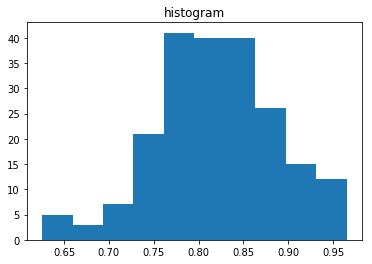

In [45]:
vals=val_stats(make_b(d1val),0.7)

('Global Mean: ', 0.8353671330266295)
('Global Std: ', 0.07040310116561906)
('Epoch: ', -1, 'with ', 0, 'below')
('Clipped Mean: ', 0.8459653391144333)
('Number clipped: ', 22, 'of total ', 565)
Suspects: 
('r442', [0.6963042616844177])
('aa675', [0.6854537129402161])
('y609', [0.2959369421005249])
('aabbccddeeffgghh675', [0.6854537129402161])
('r449', [0.6966618895530701])
('r447', [0.5655180811882019])
('n348', [0.6161811351776123])
('n341', [0.6464352011680603])
('t485', [0.44772231578826904])
('n329', [0.5658812522888184])
('n326', [0.6179893016815186])
('l285', [0.5482037663459778])
('b30', [0.47712504863739014])
('r450', [0.4813278317451477])
('r436', [0.2578932046890259])
('cc702', [0.6878083348274231])
('cc703', [0.6750361919403076])
('l296', [0.5145038962364197])
('c69', [0.6876465082168579])
('c61', [0.6860707402229309])
('j227', [0.5032594203948975])
('n336', [0.5848382711410522])
--
--
Min: 0.258
Q1: 0.823
Median: 0.854
Q3: 0.871
Max: 0.926


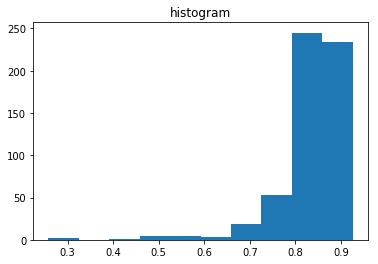

In [46]:
trans=val_stats(make_b(d1t),0.7)

In [29]:
model.load_state_dict(torch.load('sur_nucli_patch'))


In [182]:
torch.save(model.state_dict(),'sur_nucli_patch')

# Patch by Patch loss

In [62]:
def trainer_patch(model,epochs,loaders=None,opt=opt):
    global my_dict,my_dict_val,L,Lc,Ldc,L_r,Lv,Lvc,Lvdc,Lsur
    if loaders==None:
        data_loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2)
        val_loader=DataLoader(dataset_val,batch_size_val,shuffle=True, num_workers=2) 
        loaders={'train':data_loader,'val': val_loader}
    for epoch in range(epochs):
        for e in loaders:
            if e=='train':  model.train() ; grad=True  
            else: model.eval() ; grad=False
            with torch.set_grad_enabled(grad):    
                for idx, batch_data in enumerate(loaders[e]):

                    name=batch_data['name']
                    input = Variable(batch_data['image'].float()).cuda()
                    dice_mask = Variable(batch_data['mask'].float()).cuda()
                    ce_tar=Variable(batch_data['mask2']).cuda()
                    
                    pred_mask = model(input)
#                     print(pred_mask.size())
                    pred_mask1=pred_mask#[:,:,:100,:100]
#                     print(pred_mask1.requires_grad)
                    
                    ce_tar=ce_tar#[:,:100,:100]
                    ce = loss_fn(pred_mask1, ce_tar.long())
                    soft_mask=soft_max(pred_mask1)
                    
                    dice_mask1=dice_mask#[:,:,:100,:100]
                    a,b=dice_loss_classes(soft_mask, dice_mask1)
                    
                    loss = ce+ (a+b)/2 

                    if e=='train':
                        for names in name:
                            if names not in my_dict.keys(): my_dict[names]=[[1-a.item()],[1-b.item()]]
                            else: my_dict[names][0].append(1-a.item()); my_dict[names][1].append(1-b.item())
                        Lc=np.concatenate((np.array([ce.item()]), Lc)); cross_moving_avg=np.mean(Lc)
                        Ldc=np.concatenate((np.array([b.item()]), Ldc)); dice1=np.mean(Ldc)
                        L_r=np.concatenate((np.array([a.item()]), L_r)); dice0=np.mean(L_r)
                        L=np.concatenate((np.array([loss.item()]), L)); loss_moving_avg=np.mean(L)

                        print('Epo:', epoch+1, 'Btch:',idx+1,'Dce0:', round(dice0,4),'Dce1:', round(dice1,4), 'CE:',round(cross_moving_avg,5),'L:' ,round(loss_moving_avg,3))
                        loss.backward()
                        opt.step()
                        opt.zero_grad()
                    else:
                        for names in name:
                            if names not in my_dict_val.keys(): my_dict_val[names]=[[1-a.item()],[1-b.item()]]
                            else: my_dict_val[names][0].append(1-a.item()); my_dict_val[names][1].append(1-b.item())
                        print('Val Dice0', round(a.item(),3),' Dice1: ', round(b.item(),3), ' CE: ',round(ce.item(),3),' Loss :' ,round(loss_moving_avg,6) )
                        Lv=np.concatenate((np.array([loss.item()]), Lv)) ; lv_avg=np.mean(Lv)
                        Lvc=np.concatenate((np.array([ce.item()]), Lvc)) ;lvc_avg=np.mean(Lvc)
                        Lvdc=np.concatenate((np.array([b.item()]), Lvdc))
def trainer(model,epochs,loaders=None,opt=opt):
    global my_dict,my_dict_val,L,Lc,Ldc,L_r,Lv,Lvc,Lvdc
    if loaders==None:
        data_loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2)
        val_loader=DataLoader(dataset_val,batch_size_val,shuffle=True, num_workers=2) 
        loaders={'train':data_loader,'val': val_loader}
    for epoch in range(epochs):
        for e in loaders:
            if e=='train':  model.train() ; grad=True  
            else: model.eval() ; grad=False
            with torch.set_grad_enabled(grad):    
                for idx, batch_data in enumerate(loaders[e]):

                    name=batch_data['name']
                    input = Variable(batch_data['image'].float()).cuda()
                    dice_mask = Variable(batch_data['mask'].float()).cuda()
                    ce_tar=Variable(batch_data['mask2']).cuda()
                    pred_mask = model(input)
                    ce = loss_fn(pred_mask, ce_tar.long())
                    soft_mask=soft_max(pred_mask)
                    a,b=dice_loss_classes(soft_mask, dice_mask)
                    loss = ce+(a+b)/2  
                    if e=='train':
                        for names in name:
                            if names not in my_dict.keys(): my_dict[names]=[[1-a.item()],[1-b.item()]]
                            else: my_dict[names][0].append(1-a.item()); my_dict[names][1].append(1-b.item())
                        Lc=np.concatenate((np.array([ce.item()]), Lc)); cross_moving_avg=np.mean(Lc)
                        Ldc=np.concatenate((np.array([b.item()]), Ldc)); dice1=np.mean(Ldc)
                        L_r=np.concatenate((np.array([a.item()]), L_r)); dice0=np.mean(L_r)
                        L=np.concatenate((np.array([loss.item()]), L)); loss_moving_avg=np.mean(L)
                        print('Epo: ', epoch+1, ' Btch: ',idx+1,' Dce0: ', round(dice0,3),' Dce1: ', round(dice1,3), ' CE: ',round(cross_moving_avg,3),' Loss :' ,round(loss_moving_avg,3))
                        loss.backward()
                        opt.step()
                        opt.zero_grad()
                    else:
                        for names in name:
                            if names not in my_dict_val.keys(): my_dict_val[names]=[[1-a.item()],[1-b.item()]]
                            else: my_dict_val[names][0].append(1-a.item()); my_dict_val[names][1].append(1-b.item())
                        print('Val Dice0', round(a.item(),3),' Dice1: ', round(b.item(),3), ' CE: ',round(ce.item(),3),' Loss :' ,round(loss_moving_avg,6) )
                        Lv=np.concatenate((np.array([loss.item()]), Lv)) ; lv_avg=np.mean(Lv)
                        Lvc=np.concatenate((np.array([ce.item()]), Lvc)) ;lvc_avg=np.mean(Lvc)
                        Lvdc=np.concatenate((np.array([b.item()]), Lvdc))

In [63]:
my_dict={}
my_dict_val={}
Lsur=np.array([]);L=np.array([]);Lc=np.array([]);Ld=np.array([]);Lv=np.array([]);Lvd=np.array([]);Lvc=np.array([]);L_r=np.array([]);Ldc=np.array([]);Lvdc=np.array([])
loss_fn = torch.nn.CrossEntropyLoss()  ; soft_max=torch.nn.Softmax(dim=1)
init_lr=0.001 ; opt = torch.optim.Adam(model.parameters(), lr=init_lr)

In [64]:
model=UNet(3,2).cuda()
batch_size=6;batch_size_val=6
dataset = NDataset('train');dataset_val=NDataset('val')    #val
data_loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2);val_loader=DataLoader(dataset_val,batch_size_val,shuffle=True, num_workers=2) 
loaders={'train':data_loader,'val': val_loader}

In [199]:
data_loader2 = DataLoader(dataset2, batch_size//2, shuffle=True, num_workers=2) # decrease bs's for more updates
val_loader2=DataLoader(dataset_val2,batch_size_val//2,shuffle=True, num_workers=2) 
loaders2={'train':data_loader2,'val': val_loader2}

trainer(model2,80,loaders2,opt2)

('Epoch: ', 1, ' Batch: ', 1, ' Dice0: ', 0.007, ' Dice1: ', 0.235, ' CE: ', 0.021, ' Loss :', 0.143)
('Epoch: ', 1, ' Batch: ', 2, ' Dice0: ', 0.007, ' Dice1: ', 0.236, ' CE: ', 0.022, ' Loss :', 0.143)
('Epoch: ', 1, ' Batch: ', 3, ' Dice0: ', 0.007, ' Dice1: ', 0.236, ' CE: ', 0.022, ' Loss :', 0.143)
('Epoch: ', 1, ' Batch: ', 4, ' Dice0: ', 0.007, ' Dice1: ', 0.236, ' CE: ', 0.022, ' Loss :', 0.143)
('Epoch: ', 1, ' Batch: ', 5, ' Dice0: ', 0.007, ' Dice1: ', 0.236, ' CE: ', 0.022, ' Loss :', 0.143)
('Epoch: ', 1, ' Batch: ', 6, ' Dice0: ', 0.007, ' Dice1: ', 0.236, ' CE: ', 0.022, ' Loss :', 0.144)
('Epoch: ', 1, ' Batch: ', 7, ' Dice0: ', 0.007, ' Dice1: ', 0.237, ' CE: ', 0.022, ' Loss :', 0.144)
('Epoch: ', 1, ' Batch: ', 8, ' Dice0: ', 0.007, ' Dice1: ', 0.237, ' CE: ', 0.022, ' Loss :', 0.144)
('Epoch: ', 1, ' Batch: ', 9, ' Dice0: ', 0.007, ' Dice1: ', 0.237, ' CE: ', 0.022, ' Loss :', 0.144)
('Epoch: ', 1, ' Batch: ', 10, ' Dice0: ', 0.007, ' Dice1: ', 0.237, ' CE: ', 0.02

('Epoch: ', 6, ' Batch: ', 1, ' Dice0: ', 0.007, ' Dice1: ', 0.238, ' CE: ', 0.023, ' Loss :', 0.146)
('Epoch: ', 6, ' Batch: ', 2, ' Dice0: ', 0.007, ' Dice1: ', 0.238, ' CE: ', 0.023, ' Loss :', 0.145)
('Epoch: ', 6, ' Batch: ', 3, ' Dice0: ', 0.007, ' Dice1: ', 0.238, ' CE: ', 0.023, ' Loss :', 0.145)
('Epoch: ', 6, ' Batch: ', 4, ' Dice0: ', 0.007, ' Dice1: ', 0.239, ' CE: ', 0.023, ' Loss :', 0.146)
('Epoch: ', 6, ' Batch: ', 5, ' Dice0: ', 0.007, ' Dice1: ', 0.239, ' CE: ', 0.023, ' Loss :', 0.146)
('Epoch: ', 6, ' Batch: ', 6, ' Dice0: ', 0.007, ' Dice1: ', 0.239, ' CE: ', 0.023, ' Loss :', 0.146)
('Epoch: ', 6, ' Batch: ', 7, ' Dice0: ', 0.007, ' Dice1: ', 0.239, ' CE: ', 0.023, ' Loss :', 0.146)
('Epoch: ', 6, ' Batch: ', 8, ' Dice0: ', 0.007, ' Dice1: ', 0.239, ' CE: ', 0.023, ' Loss :', 0.146)
('Epoch: ', 6, ' Batch: ', 9, ' Dice0: ', 0.007, ' Dice1: ', 0.239, ' CE: ', 0.023, ' Loss :', 0.146)
('Epoch: ', 6, ' Batch: ', 10, ' Dice0: ', 0.007, ' Dice1: ', 0.239, ' CE: ', 0.02

('Epoch: ', 11, ' Batch: ', 1, ' Dice0: ', 0.007, ' Dice1: ', 0.236, ' CE: ', 0.023, ' Loss :', 0.145)
('Epoch: ', 11, ' Batch: ', 2, ' Dice0: ', 0.007, ' Dice1: ', 0.236, ' CE: ', 0.023, ' Loss :', 0.145)
('Epoch: ', 11, ' Batch: ', 3, ' Dice0: ', 0.007, ' Dice1: ', 0.236, ' CE: ', 0.023, ' Loss :', 0.144)
('Epoch: ', 11, ' Batch: ', 4, ' Dice0: ', 0.007, ' Dice1: ', 0.236, ' CE: ', 0.023, ' Loss :', 0.144)
('Epoch: ', 11, ' Batch: ', 5, ' Dice0: ', 0.007, ' Dice1: ', 0.236, ' CE: ', 0.023, ' Loss :', 0.144)
('Epoch: ', 11, ' Batch: ', 6, ' Dice0: ', 0.007, ' Dice1: ', 0.236, ' CE: ', 0.023, ' Loss :', 0.144)
('Epoch: ', 11, ' Batch: ', 7, ' Dice0: ', 0.007, ' Dice1: ', 0.236, ' CE: ', 0.023, ' Loss :', 0.144)
('Epoch: ', 11, ' Batch: ', 8, ' Dice0: ', 0.007, ' Dice1: ', 0.236, ' CE: ', 0.023, ' Loss :', 0.144)
('Epoch: ', 11, ' Batch: ', 9, ' Dice0: ', 0.007, ' Dice1: ', 0.236, ' CE: ', 0.023, ' Loss :', 0.144)
('Epoch: ', 11, ' Batch: ', 10, ' Dice0: ', 0.007, ' Dice1: ', 0.236, ' C

('Epoch: ', 16, ' Batch: ', 1, ' Dice0: ', 0.007, ' Dice1: ', 0.233, ' CE: ', 0.023, ' Loss :', 0.142)
('Epoch: ', 16, ' Batch: ', 2, ' Dice0: ', 0.007, ' Dice1: ', 0.232, ' CE: ', 0.023, ' Loss :', 0.142)
('Epoch: ', 16, ' Batch: ', 3, ' Dice0: ', 0.007, ' Dice1: ', 0.232, ' CE: ', 0.023, ' Loss :', 0.142)
('Epoch: ', 16, ' Batch: ', 4, ' Dice0: ', 0.007, ' Dice1: ', 0.232, ' CE: ', 0.023, ' Loss :', 0.142)
('Epoch: ', 16, ' Batch: ', 5, ' Dice0: ', 0.007, ' Dice1: ', 0.232, ' CE: ', 0.023, ' Loss :', 0.142)
('Epoch: ', 16, ' Batch: ', 6, ' Dice0: ', 0.007, ' Dice1: ', 0.232, ' CE: ', 0.023, ' Loss :', 0.142)
('Epoch: ', 16, ' Batch: ', 7, ' Dice0: ', 0.007, ' Dice1: ', 0.232, ' CE: ', 0.023, ' Loss :', 0.142)
('Epoch: ', 16, ' Batch: ', 8, ' Dice0: ', 0.007, ' Dice1: ', 0.232, ' CE: ', 0.023, ' Loss :', 0.142)
('Epoch: ', 16, ' Batch: ', 9, ' Dice0: ', 0.007, ' Dice1: ', 0.232, ' CE: ', 0.023, ' Loss :', 0.142)
('Epoch: ', 16, ' Batch: ', 10, ' Dice0: ', 0.007, ' Dice1: ', 0.232, ' C

('Epoch: ', 21, ' Batch: ', 1, ' Dice0: ', 0.007, ' Dice1: ', 0.228, ' CE: ', 0.022, ' Loss :', 0.139)
('Epoch: ', 21, ' Batch: ', 2, ' Dice0: ', 0.007, ' Dice1: ', 0.228, ' CE: ', 0.022, ' Loss :', 0.139)
('Epoch: ', 21, ' Batch: ', 3, ' Dice0: ', 0.007, ' Dice1: ', 0.228, ' CE: ', 0.022, ' Loss :', 0.139)
('Epoch: ', 21, ' Batch: ', 4, ' Dice0: ', 0.007, ' Dice1: ', 0.227, ' CE: ', 0.022, ' Loss :', 0.139)
('Epoch: ', 21, ' Batch: ', 5, ' Dice0: ', 0.007, ' Dice1: ', 0.227, ' CE: ', 0.022, ' Loss :', 0.139)
('Epoch: ', 21, ' Batch: ', 6, ' Dice0: ', 0.007, ' Dice1: ', 0.227, ' CE: ', 0.022, ' Loss :', 0.139)
('Epoch: ', 21, ' Batch: ', 7, ' Dice0: ', 0.007, ' Dice1: ', 0.227, ' CE: ', 0.022, ' Loss :', 0.139)
('Epoch: ', 21, ' Batch: ', 8, ' Dice0: ', 0.007, ' Dice1: ', 0.227, ' CE: ', 0.022, ' Loss :', 0.139)
('Epoch: ', 21, ' Batch: ', 9, ' Dice0: ', 0.007, ' Dice1: ', 0.227, ' CE: ', 0.022, ' Loss :', 0.139)
('Epoch: ', 21, ' Batch: ', 10, ' Dice0: ', 0.007, ' Dice1: ', 0.227, ' C

('Epoch: ', 26, ' Batch: ', 1, ' Dice0: ', 0.006, ' Dice1: ', 0.223, ' CE: ', 0.022, ' Loss :', 0.136)
('Epoch: ', 26, ' Batch: ', 2, ' Dice0: ', 0.006, ' Dice1: ', 0.223, ' CE: ', 0.022, ' Loss :', 0.136)
('Epoch: ', 26, ' Batch: ', 3, ' Dice0: ', 0.006, ' Dice1: ', 0.223, ' CE: ', 0.022, ' Loss :', 0.136)
('Epoch: ', 26, ' Batch: ', 4, ' Dice0: ', 0.006, ' Dice1: ', 0.223, ' CE: ', 0.022, ' Loss :', 0.136)
('Epoch: ', 26, ' Batch: ', 5, ' Dice0: ', 0.006, ' Dice1: ', 0.222, ' CE: ', 0.022, ' Loss :', 0.136)
('Epoch: ', 26, ' Batch: ', 6, ' Dice0: ', 0.006, ' Dice1: ', 0.222, ' CE: ', 0.022, ' Loss :', 0.136)
('Epoch: ', 26, ' Batch: ', 7, ' Dice0: ', 0.006, ' Dice1: ', 0.222, ' CE: ', 0.022, ' Loss :', 0.136)
('Epoch: ', 26, ' Batch: ', 8, ' Dice0: ', 0.006, ' Dice1: ', 0.222, ' CE: ', 0.022, ' Loss :', 0.136)
('Epoch: ', 26, ' Batch: ', 9, ' Dice0: ', 0.006, ' Dice1: ', 0.222, ' CE: ', 0.022, ' Loss :', 0.136)
('Epoch: ', 26, ' Batch: ', 10, ' Dice0: ', 0.006, ' Dice1: ', 0.222, ' C

('Epoch: ', 31, ' Batch: ', 1, ' Dice0: ', 0.006, ' Dice1: ', 0.218, ' CE: ', 0.021, ' Loss :', 0.133)
('Epoch: ', 31, ' Batch: ', 2, ' Dice0: ', 0.006, ' Dice1: ', 0.218, ' CE: ', 0.021, ' Loss :', 0.133)
('Epoch: ', 31, ' Batch: ', 3, ' Dice0: ', 0.006, ' Dice1: ', 0.218, ' CE: ', 0.021, ' Loss :', 0.133)
('Epoch: ', 31, ' Batch: ', 4, ' Dice0: ', 0.006, ' Dice1: ', 0.218, ' CE: ', 0.021, ' Loss :', 0.133)
('Epoch: ', 31, ' Batch: ', 5, ' Dice0: ', 0.006, ' Dice1: ', 0.218, ' CE: ', 0.021, ' Loss :', 0.133)
('Epoch: ', 31, ' Batch: ', 6, ' Dice0: ', 0.006, ' Dice1: ', 0.218, ' CE: ', 0.021, ' Loss :', 0.133)
('Epoch: ', 31, ' Batch: ', 7, ' Dice0: ', 0.006, ' Dice1: ', 0.218, ' CE: ', 0.021, ' Loss :', 0.133)
('Epoch: ', 31, ' Batch: ', 8, ' Dice0: ', 0.006, ' Dice1: ', 0.218, ' CE: ', 0.021, ' Loss :', 0.133)
('Epoch: ', 31, ' Batch: ', 9, ' Dice0: ', 0.006, ' Dice1: ', 0.217, ' CE: ', 0.021, ' Loss :', 0.133)
('Epoch: ', 31, ' Batch: ', 10, ' Dice0: ', 0.006, ' Dice1: ', 0.217, ' C

('Epoch: ', 36, ' Batch: ', 1, ' Dice0: ', 0.006, ' Dice1: ', 0.213, ' CE: ', 0.021, ' Loss :', 0.13)
('Epoch: ', 36, ' Batch: ', 2, ' Dice0: ', 0.006, ' Dice1: ', 0.213, ' CE: ', 0.021, ' Loss :', 0.13)
('Epoch: ', 36, ' Batch: ', 3, ' Dice0: ', 0.006, ' Dice1: ', 0.213, ' CE: ', 0.021, ' Loss :', 0.13)
('Epoch: ', 36, ' Batch: ', 4, ' Dice0: ', 0.006, ' Dice1: ', 0.213, ' CE: ', 0.021, ' Loss :', 0.13)
('Epoch: ', 36, ' Batch: ', 5, ' Dice0: ', 0.006, ' Dice1: ', 0.213, ' CE: ', 0.021, ' Loss :', 0.13)
('Epoch: ', 36, ' Batch: ', 6, ' Dice0: ', 0.006, ' Dice1: ', 0.212, ' CE: ', 0.021, ' Loss :', 0.13)
('Epoch: ', 36, ' Batch: ', 7, ' Dice0: ', 0.006, ' Dice1: ', 0.212, ' CE: ', 0.021, ' Loss :', 0.13)
('Epoch: ', 36, ' Batch: ', 8, ' Dice0: ', 0.006, ' Dice1: ', 0.212, ' CE: ', 0.021, ' Loss :', 0.13)
('Epoch: ', 36, ' Batch: ', 9, ' Dice0: ', 0.006, ' Dice1: ', 0.212, ' CE: ', 0.021, ' Loss :', 0.13)
('Epoch: ', 36, ' Batch: ', 10, ' Dice0: ', 0.006, ' Dice1: ', 0.212, ' CE: ', 0.0

('Epoch: ', 41, ' Batch: ', 1, ' Dice0: ', 0.006, ' Dice1: ', 0.208, ' CE: ', 0.02, ' Loss :', 0.127)
('Epoch: ', 41, ' Batch: ', 2, ' Dice0: ', 0.006, ' Dice1: ', 0.208, ' CE: ', 0.02, ' Loss :', 0.127)
('Epoch: ', 41, ' Batch: ', 3, ' Dice0: ', 0.006, ' Dice1: ', 0.208, ' CE: ', 0.02, ' Loss :', 0.127)
('Epoch: ', 41, ' Batch: ', 4, ' Dice0: ', 0.006, ' Dice1: ', 0.208, ' CE: ', 0.02, ' Loss :', 0.127)
('Epoch: ', 41, ' Batch: ', 5, ' Dice0: ', 0.006, ' Dice1: ', 0.207, ' CE: ', 0.02, ' Loss :', 0.127)
('Epoch: ', 41, ' Batch: ', 6, ' Dice0: ', 0.006, ' Dice1: ', 0.207, ' CE: ', 0.02, ' Loss :', 0.127)
('Epoch: ', 41, ' Batch: ', 7, ' Dice0: ', 0.006, ' Dice1: ', 0.207, ' CE: ', 0.02, ' Loss :', 0.127)
('Epoch: ', 41, ' Batch: ', 8, ' Dice0: ', 0.006, ' Dice1: ', 0.207, ' CE: ', 0.02, ' Loss :', 0.127)
('Epoch: ', 41, ' Batch: ', 9, ' Dice0: ', 0.006, ' Dice1: ', 0.207, ' CE: ', 0.02, ' Loss :', 0.127)
('Epoch: ', 41, ' Batch: ', 10, ' Dice0: ', 0.006, ' Dice1: ', 0.207, ' CE: ', 0.0

('Epoch: ', 46, ' Batch: ', 1, ' Dice0: ', 0.006, ' Dice1: ', 0.203, ' CE: ', 0.02, ' Loss :', 0.124)
('Epoch: ', 46, ' Batch: ', 2, ' Dice0: ', 0.006, ' Dice1: ', 0.203, ' CE: ', 0.02, ' Loss :', 0.124)
('Epoch: ', 46, ' Batch: ', 3, ' Dice0: ', 0.006, ' Dice1: ', 0.203, ' CE: ', 0.02, ' Loss :', 0.124)
('Epoch: ', 46, ' Batch: ', 4, ' Dice0: ', 0.006, ' Dice1: ', 0.203, ' CE: ', 0.02, ' Loss :', 0.124)
('Epoch: ', 46, ' Batch: ', 5, ' Dice0: ', 0.006, ' Dice1: ', 0.203, ' CE: ', 0.02, ' Loss :', 0.124)
('Epoch: ', 46, ' Batch: ', 6, ' Dice0: ', 0.006, ' Dice1: ', 0.203, ' CE: ', 0.02, ' Loss :', 0.124)
('Epoch: ', 46, ' Batch: ', 7, ' Dice0: ', 0.006, ' Dice1: ', 0.203, ' CE: ', 0.02, ' Loss :', 0.124)
('Epoch: ', 46, ' Batch: ', 8, ' Dice0: ', 0.006, ' Dice1: ', 0.202, ' CE: ', 0.02, ' Loss :', 0.124)
('Epoch: ', 46, ' Batch: ', 9, ' Dice0: ', 0.006, ' Dice1: ', 0.202, ' CE: ', 0.02, ' Loss :', 0.124)
('Epoch: ', 46, ' Batch: ', 10, ' Dice0: ', 0.006, ' Dice1: ', 0.202, ' CE: ', 0.0

('Epoch: ', 51, ' Batch: ', 1, ' Dice0: ', 0.006, ' Dice1: ', 0.198, ' CE: ', 0.019, ' Loss :', 0.121)
('Epoch: ', 51, ' Batch: ', 2, ' Dice0: ', 0.006, ' Dice1: ', 0.198, ' CE: ', 0.019, ' Loss :', 0.121)
('Epoch: ', 51, ' Batch: ', 3, ' Dice0: ', 0.006, ' Dice1: ', 0.198, ' CE: ', 0.019, ' Loss :', 0.121)
('Epoch: ', 51, ' Batch: ', 4, ' Dice0: ', 0.006, ' Dice1: ', 0.198, ' CE: ', 0.019, ' Loss :', 0.121)
('Epoch: ', 51, ' Batch: ', 5, ' Dice0: ', 0.006, ' Dice1: ', 0.198, ' CE: ', 0.019, ' Loss :', 0.121)
('Epoch: ', 51, ' Batch: ', 6, ' Dice0: ', 0.006, ' Dice1: ', 0.198, ' CE: ', 0.019, ' Loss :', 0.121)
('Epoch: ', 51, ' Batch: ', 7, ' Dice0: ', 0.006, ' Dice1: ', 0.198, ' CE: ', 0.019, ' Loss :', 0.121)
('Epoch: ', 51, ' Batch: ', 8, ' Dice0: ', 0.006, ' Dice1: ', 0.198, ' CE: ', 0.019, ' Loss :', 0.121)
('Epoch: ', 51, ' Batch: ', 9, ' Dice0: ', 0.006, ' Dice1: ', 0.198, ' CE: ', 0.019, ' Loss :', 0.121)
('Epoch: ', 51, ' Batch: ', 10, ' Dice0: ', 0.006, ' Dice1: ', 0.198, ' C

('Epoch: ', 56, ' Batch: ', 1, ' Dice0: ', 0.005, ' Dice1: ', 0.194, ' CE: ', 0.019, ' Loss :', 0.119)
('Epoch: ', 56, ' Batch: ', 2, ' Dice0: ', 0.005, ' Dice1: ', 0.194, ' CE: ', 0.019, ' Loss :', 0.119)
('Epoch: ', 56, ' Batch: ', 3, ' Dice0: ', 0.005, ' Dice1: ', 0.194, ' CE: ', 0.019, ' Loss :', 0.119)
('Epoch: ', 56, ' Batch: ', 4, ' Dice0: ', 0.005, ' Dice1: ', 0.194, ' CE: ', 0.019, ' Loss :', 0.119)
('Epoch: ', 56, ' Batch: ', 5, ' Dice0: ', 0.005, ' Dice1: ', 0.194, ' CE: ', 0.019, ' Loss :', 0.119)
('Epoch: ', 56, ' Batch: ', 6, ' Dice0: ', 0.005, ' Dice1: ', 0.194, ' CE: ', 0.019, ' Loss :', 0.119)
('Epoch: ', 56, ' Batch: ', 7, ' Dice0: ', 0.005, ' Dice1: ', 0.194, ' CE: ', 0.019, ' Loss :', 0.119)
('Epoch: ', 56, ' Batch: ', 8, ' Dice0: ', 0.005, ' Dice1: ', 0.194, ' CE: ', 0.019, ' Loss :', 0.119)
('Epoch: ', 56, ' Batch: ', 9, ' Dice0: ', 0.005, ' Dice1: ', 0.194, ' CE: ', 0.019, ' Loss :', 0.119)
('Epoch: ', 56, ' Batch: ', 10, ' Dice0: ', 0.005, ' Dice1: ', 0.194, ' C

('Epoch: ', 61, ' Batch: ', 1, ' Dice0: ', 0.005, ' Dice1: ', 0.191, ' CE: ', 0.019, ' Loss :', 0.117)
('Epoch: ', 61, ' Batch: ', 2, ' Dice0: ', 0.005, ' Dice1: ', 0.191, ' CE: ', 0.019, ' Loss :', 0.117)
('Epoch: ', 61, ' Batch: ', 3, ' Dice0: ', 0.005, ' Dice1: ', 0.191, ' CE: ', 0.019, ' Loss :', 0.117)
('Epoch: ', 61, ' Batch: ', 4, ' Dice0: ', 0.005, ' Dice1: ', 0.19, ' CE: ', 0.019, ' Loss :', 0.117)
('Epoch: ', 61, ' Batch: ', 5, ' Dice0: ', 0.005, ' Dice1: ', 0.19, ' CE: ', 0.019, ' Loss :', 0.117)
('Epoch: ', 61, ' Batch: ', 6, ' Dice0: ', 0.005, ' Dice1: ', 0.19, ' CE: ', 0.019, ' Loss :', 0.116)
('Epoch: ', 61, ' Batch: ', 7, ' Dice0: ', 0.005, ' Dice1: ', 0.19, ' CE: ', 0.019, ' Loss :', 0.116)
('Epoch: ', 61, ' Batch: ', 8, ' Dice0: ', 0.005, ' Dice1: ', 0.19, ' CE: ', 0.019, ' Loss :', 0.116)
('Epoch: ', 61, ' Batch: ', 9, ' Dice0: ', 0.005, ' Dice1: ', 0.19, ' CE: ', 0.019, ' Loss :', 0.116)
('Epoch: ', 61, ' Batch: ', 10, ' Dice0: ', 0.005, ' Dice1: ', 0.19, ' CE: ', 0

('Epoch: ', 66, ' Batch: ', 1, ' Dice0: ', 0.005, ' Dice1: ', 0.187, ' CE: ', 0.018, ' Loss :', 0.114)
('Epoch: ', 66, ' Batch: ', 2, ' Dice0: ', 0.005, ' Dice1: ', 0.187, ' CE: ', 0.018, ' Loss :', 0.114)
('Epoch: ', 66, ' Batch: ', 3, ' Dice0: ', 0.005, ' Dice1: ', 0.187, ' CE: ', 0.018, ' Loss :', 0.114)
('Epoch: ', 66, ' Batch: ', 4, ' Dice0: ', 0.005, ' Dice1: ', 0.186, ' CE: ', 0.018, ' Loss :', 0.114)
('Epoch: ', 66, ' Batch: ', 5, ' Dice0: ', 0.005, ' Dice1: ', 0.186, ' CE: ', 0.018, ' Loss :', 0.114)
('Epoch: ', 66, ' Batch: ', 6, ' Dice0: ', 0.005, ' Dice1: ', 0.186, ' CE: ', 0.018, ' Loss :', 0.114)
('Epoch: ', 66, ' Batch: ', 7, ' Dice0: ', 0.005, ' Dice1: ', 0.186, ' CE: ', 0.018, ' Loss :', 0.114)
('Epoch: ', 66, ' Batch: ', 8, ' Dice0: ', 0.005, ' Dice1: ', 0.186, ' CE: ', 0.018, ' Loss :', 0.114)
('Epoch: ', 66, ' Batch: ', 9, ' Dice0: ', 0.005, ' Dice1: ', 0.186, ' CE: ', 0.018, ' Loss :', 0.114)
('Epoch: ', 66, ' Batch: ', 10, ' Dice0: ', 0.005, ' Dice1: ', 0.186, ' C

('Epoch: ', 71, ' Batch: ', 1, ' Dice0: ', 0.005, ' Dice1: ', 0.183, ' CE: ', 0.018, ' Loss :', 0.112)
('Epoch: ', 71, ' Batch: ', 2, ' Dice0: ', 0.005, ' Dice1: ', 0.183, ' CE: ', 0.018, ' Loss :', 0.112)
('Epoch: ', 71, ' Batch: ', 3, ' Dice0: ', 0.005, ' Dice1: ', 0.183, ' CE: ', 0.018, ' Loss :', 0.112)
('Epoch: ', 71, ' Batch: ', 4, ' Dice0: ', 0.005, ' Dice1: ', 0.183, ' CE: ', 0.018, ' Loss :', 0.112)
('Epoch: ', 71, ' Batch: ', 5, ' Dice0: ', 0.005, ' Dice1: ', 0.182, ' CE: ', 0.018, ' Loss :', 0.112)
('Epoch: ', 71, ' Batch: ', 6, ' Dice0: ', 0.005, ' Dice1: ', 0.182, ' CE: ', 0.018, ' Loss :', 0.112)
('Epoch: ', 71, ' Batch: ', 7, ' Dice0: ', 0.005, ' Dice1: ', 0.182, ' CE: ', 0.018, ' Loss :', 0.112)
('Epoch: ', 71, ' Batch: ', 8, ' Dice0: ', 0.005, ' Dice1: ', 0.182, ' CE: ', 0.018, ' Loss :', 0.112)
('Epoch: ', 71, ' Batch: ', 9, ' Dice0: ', 0.005, ' Dice1: ', 0.182, ' CE: ', 0.018, ' Loss :', 0.111)
('Epoch: ', 71, ' Batch: ', 10, ' Dice0: ', 0.005, ' Dice1: ', 0.182, ' C

('Epoch: ', 76, ' Batch: ', 1, ' Dice0: ', 0.005, ' Dice1: ', 0.179, ' CE: ', 0.018, ' Loss :', 0.109)
('Epoch: ', 76, ' Batch: ', 2, ' Dice0: ', 0.005, ' Dice1: ', 0.179, ' CE: ', 0.017, ' Loss :', 0.109)
('Epoch: ', 76, ' Batch: ', 3, ' Dice0: ', 0.005, ' Dice1: ', 0.179, ' CE: ', 0.017, ' Loss :', 0.109)
('Epoch: ', 76, ' Batch: ', 4, ' Dice0: ', 0.005, ' Dice1: ', 0.179, ' CE: ', 0.017, ' Loss :', 0.109)
('Epoch: ', 76, ' Batch: ', 5, ' Dice0: ', 0.005, ' Dice1: ', 0.179, ' CE: ', 0.017, ' Loss :', 0.109)
('Epoch: ', 76, ' Batch: ', 6, ' Dice0: ', 0.005, ' Dice1: ', 0.178, ' CE: ', 0.017, ' Loss :', 0.109)
('Epoch: ', 76, ' Batch: ', 7, ' Dice0: ', 0.005, ' Dice1: ', 0.178, ' CE: ', 0.017, ' Loss :', 0.109)
('Epoch: ', 76, ' Batch: ', 8, ' Dice0: ', 0.005, ' Dice1: ', 0.178, ' CE: ', 0.017, ' Loss :', 0.109)
('Epoch: ', 76, ' Batch: ', 9, ' Dice0: ', 0.005, ' Dice1: ', 0.178, ' CE: ', 0.017, ' Loss :', 0.109)
('Epoch: ', 76, ' Batch: ', 10, ' Dice0: ', 0.005, ' Dice1: ', 0.178, ' C

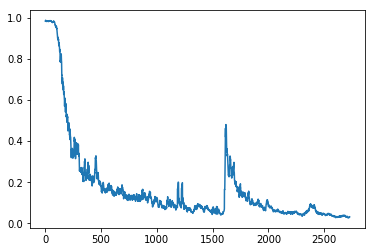

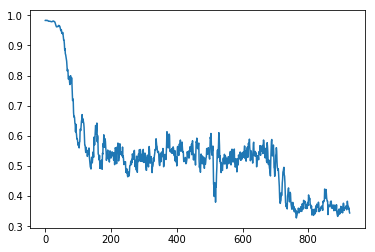

In [200]:

plt.plot(moving_average(np.flip(Ldc))); plt.show()
plt.plot(moving_average(np.flip(Lvdc))); plt.show()


In [201]:
my_dict={}
my_dict_val={}
data_loader2 = DataLoader(dataset2, 1, shuffle=True, num_workers=2) # decrease bs's for more updates
val_loader2=DataLoader(dataset_val2,1,shuffle=True, num_workers=2) 
loaders2={'train':data_loader2,'val': val_loader2}
valider(model2,loaders2)

('Epoch: ', 1, ' Batch: ', 1, ' Dice0: ', 0.005, ' Dice1: ', 0.175, ' CE: ', 0.017, ' Loss :', 0.107)
('Epoch: ', 1, ' Batch: ', 2, ' Dice0: ', 0.005, ' Dice1: ', 0.175, ' CE: ', 0.017, ' Loss :', 0.107)
('Epoch: ', 1, ' Batch: ', 3, ' Dice0: ', 0.005, ' Dice1: ', 0.175, ' CE: ', 0.017, ' Loss :', 0.107)
('Epoch: ', 1, ' Batch: ', 4, ' Dice0: ', 0.005, ' Dice1: ', 0.175, ' CE: ', 0.017, ' Loss :', 0.107)
('Epoch: ', 1, ' Batch: ', 5, ' Dice0: ', 0.005, ' Dice1: ', 0.175, ' CE: ', 0.017, ' Loss :', 0.107)
('Epoch: ', 1, ' Batch: ', 6, ' Dice0: ', 0.005, ' Dice1: ', 0.175, ' CE: ', 0.017, ' Loss :', 0.107)
('Epoch: ', 1, ' Batch: ', 7, ' Dice0: ', 0.005, ' Dice1: ', 0.175, ' CE: ', 0.017, ' Loss :', 0.107)
('Epoch: ', 1, ' Batch: ', 8, ' Dice0: ', 0.005, ' Dice1: ', 0.175, ' CE: ', 0.017, ' Loss :', 0.107)
('Epoch: ', 1, ' Batch: ', 9, ' Dice0: ', 0.005, ' Dice1: ', 0.175, ' CE: ', 0.017, ' Loss :', 0.107)
('Epoch: ', 1, ' Batch: ', 10, ' Dice0: ', 0.005, ' Dice1: ', 0.175, ' CE: ', 0.01

('Global Mean: ', 0.5977116127808889)
('Global Std: ', 0.22187541126079569)
('Epoch: ', -1, 'with ', 0, 'below')
('Number clipped: ', 12, 'of total ', 12)
Suspects: 
('P0211', [0.7604595422744751])
('P0212', [0.7096583247184753])
('P0098', [0.733039140701294])
('P0071', [0.6701338291168213])
('P0084', [0.34027302265167236])
('P0016', [5.185604095458984e-06])
('P0225', [0.6706128120422363])
('P0015', [0.46084582805633545])
('P0133', [0.7891159057617188])
('P0056', [0.6957606673240662])
('P0243', [0.7797324657440186])
('P0054', [0.5629026293754578])
--
--
Min: 0.000
Q1: 0.537
Median: 0.683
Q3: 0.740
Max: 0.789


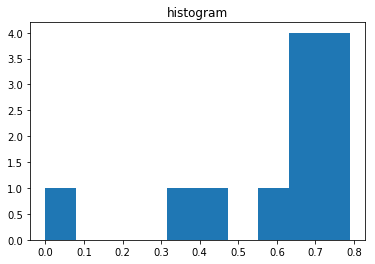

In [202]:
vals2=val_stats(make_b(my_dict_val))

('Global Mean: ', 0.9373319808925901)
('Global Std: ', 0.0767060666592866)
('Epoch: ', -1, 'with ', 0, 'below')
('Clipped Mean: ', 0.9694421180972347)
('Number clipped: ', 29, 'of total ', 56)
Suspects: 
('P0086', [0.9458372592926025])
('P0166', [0.9563416242599487])
('P0242', [0.9462301731109619])
('P0073', [0.8836387991905212])
('P0001', [0.9343465566635132])
('P0041', [0.959651529788971])
('P0029', [0.9585357308387756])
('P0042', [0.7752232551574707])
('P0100', [0.9367650151252747])
('P0101', [0.9312624335289001])
('P0226', [0.4698340892791748])
('P0222', [0.9542945027351379])
('P0009', [0.9391080141067505])
('P0199', [0.8766907453536987])
('P0213', [0.9014856815338135])
('P0151', [0.9557918310165405])
('P0196', [0.946227490901947])
('P0179', [0.9476196765899658])
('P0136', [0.8976871967315674])
('P0117', [0.9375079274177551])
('P0013', [0.9465553164482117])
('P0011', [0.9326315522193909])
('P0050', [0.9387297034263611])
('P0118', [0.9439133405685425])
('P0031', [0.9538902044296265]

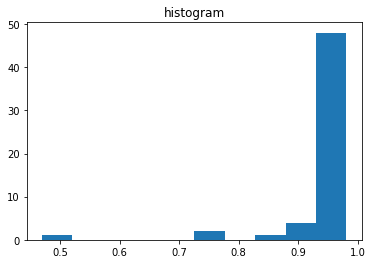

In [203]:
trans2=val_stats(make_b(my_dict),0.96)

In [193]:
diff_checker2(vals2,vals)
# vals,vals2

('P0071', ' : ', -0.6143157482147217)
('P0212', ' : ', -0.07553654909133911)
('P0098', ' : ', -0.17135274410247803)
('P0211', ' : ', -0.7704473733901978)
('P0084', ' : ', -0.2670705318450928)
('P0016', ' : ', -0.6101529002189636)
('P0015', ' : ', 0.24667054414749146)
('P0133', ' : ', -0.6879265308380127)
('P0056', ' : ', 0.02297908067703247)
('P0225', ' : ', 0.2719414234161377)
('P0243', ' : ', -0.02672046422958374)
('P0054', ' : ', 0.09298735857009888)


{'P0015': [0.526771605014801, 0.28010106086730957, 0.24667054414749146],
 'P0016': [0.03930926322937012, 0.6494621634483337, -0.6101529002189636],
 'P0054': [0.8017757534980774, 0.7087883949279785, 0.09298735857009888],
 'P0056': [0.7773027420043945, 0.7543236613273621, 0.02297908067703247],
 'P0071': [0.11850279569625854, 0.7328185439109802, -0.6143157482147217],
 'P0084': [0.47959959506988525, 0.746670126914978, -0.2670705318450928],
 'P0098': [0.6201017498970032, 0.7914544939994812, -0.17135274410247803],
 'P0133': [0.03305536508560181, 0.7209818959236145, -0.6879265308380127],
 'P0211': [0.00033080577850341797, 0.7707781791687012, -0.7704473733901978],
 'P0212': [0.6125690340995789, 0.688105583190918, -0.07553654909133911],
 'P0225': [0.5979064106941223, 0.3259649872779846, 0.2719414234161377],
 'P0243': [0.7632434368133545, 0.7899639010429382, -0.02672046422958374]}

In [204]:
diff_checker2(vals2,vals)


('P0211', ' : ', -0.010318636894226074)
('P0212', ' : ', 0.021552741527557373)
('P0098', ' : ', -0.058415353298187256)
('P0071', ' : ', -0.06268471479415894)
('P0084', ' : ', -0.40639710426330566)
('P0016', ' : ', -0.6494569778442383)
('P0015', ' : ', 0.18074476718902588)
('P0133', ' : ', 0.06813400983810425)
('P0056', ' : ', -0.0585629940032959)
('P0225', ' : ', 0.3446478247642517)
('P0243', ' : ', -0.010231435298919678)
('P0054', ' : ', -0.14588576555252075)


{'P0015': [0.46084582805633545, 0.28010106086730957, 0.18074476718902588],
 'P0016': [5.185604095458984e-06, 0.6494621634483337, -0.6494569778442383],
 'P0054': [0.5629026293754578, 0.7087883949279785, -0.14588576555252075],
 'P0056': [0.6957606673240662, 0.7543236613273621, -0.0585629940032959],
 'P0071': [0.6701338291168213, 0.7328185439109802, -0.06268471479415894],
 'P0084': [0.34027302265167236, 0.746670126914978, -0.40639710426330566],
 'P0098': [0.733039140701294, 0.7914544939994812, -0.058415353298187256],
 'P0133': [0.7891159057617188, 0.7209818959236145, 0.06813400983810425],
 'P0211': [0.7604595422744751, 0.7707781791687012, -0.010318636894226074],
 'P0212': [0.7096583247184753, 0.688105583190918, 0.021552741527557373],
 'P0225': [0.6706128120422363, 0.3259649872779846, 0.3446478247642517],
 'P0243': [0.7797324657440186, 0.7899639010429382, -0.010231435298919678]}

('c63', tensor(0.7792, device='cuda:0'))


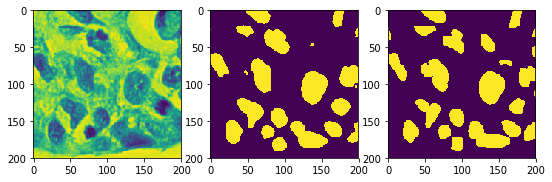

('m317', tensor(0.7782, device='cuda:0'))


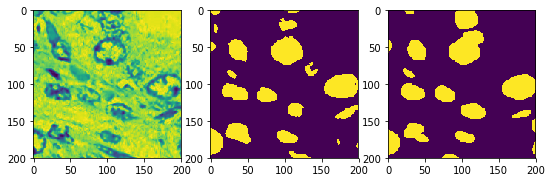

('i201', tensor(0.8051, device='cuda:0'))


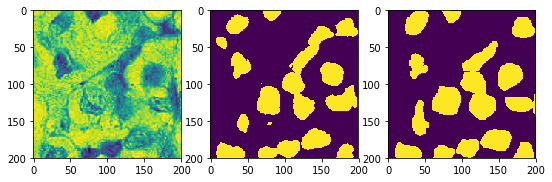

('x586', tensor(0.7713, device='cuda:0'))


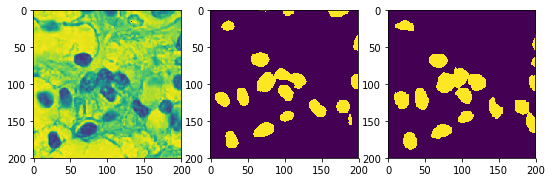

('y612', tensor(0.8067, device='cuda:0'))


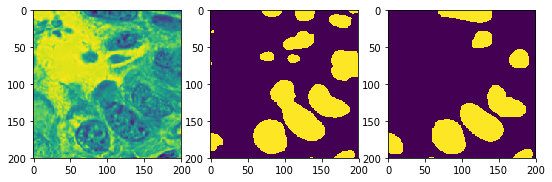

('v533', tensor(0.7752, device='cuda:0'))


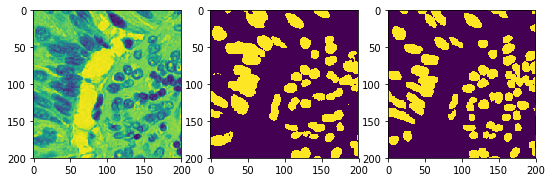

('v531', tensor(0.7909, device='cuda:0'))


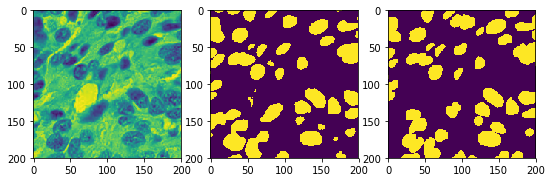

('d94', tensor(0.8327, device='cuda:0'))


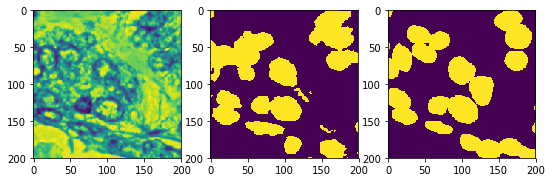

('r430', tensor(0.8181, device='cuda:0'))


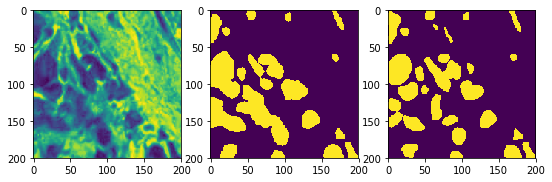

('cc709', tensor(0.7988, device='cuda:0'))


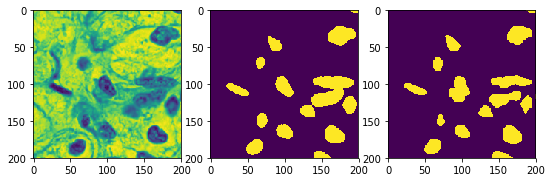

('d98', tensor(0.8167, device='cuda:0'))


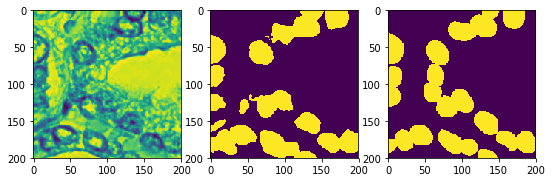

('s463', tensor(0.7507, device='cuda:0'))


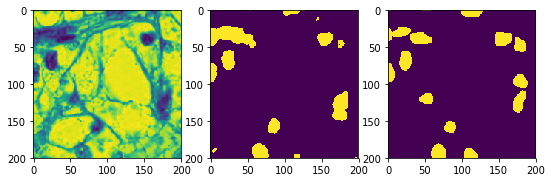

('bb699', tensor(0.7935, device='cuda:0'))


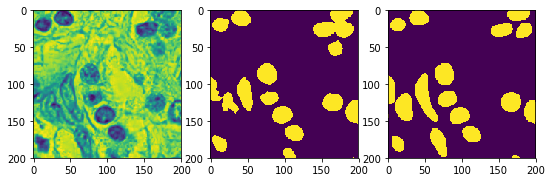

('e124', tensor(0.7830, device='cuda:0'))


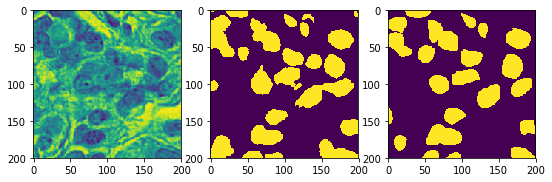

('cc723', tensor(0.7809, device='cuda:0'))


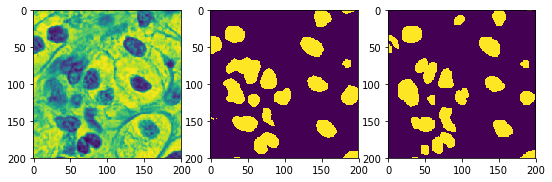

('s465', tensor(0.8368, device='cuda:0'))


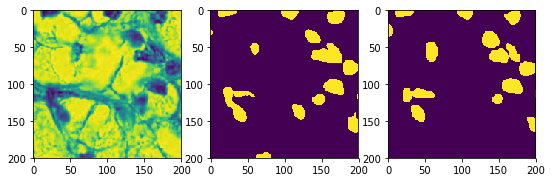

('s451', tensor(0.7843, device='cuda:0'))


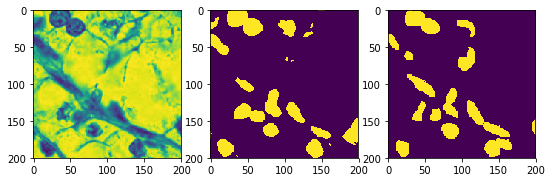

('aabbccddee666', tensor(0.8424, device='cuda:0'))


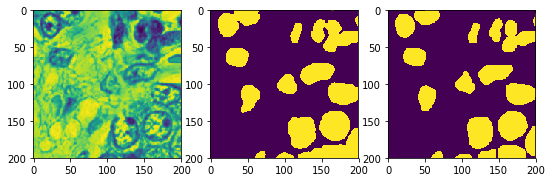

('k252', tensor(0.8250, device='cuda:0'))


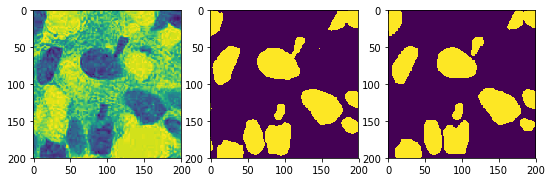

('cc713', tensor(0.8067, device='cuda:0'))


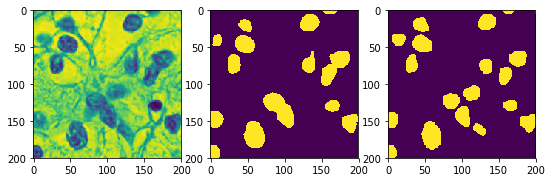

('q411', tensor(0.8235, device='cuda:0'))


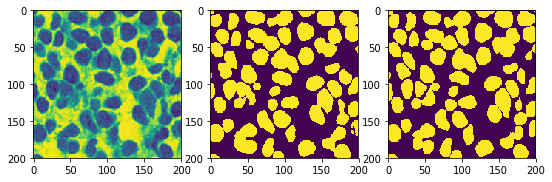

('aa658', tensor(0.8478, device='cuda:0'))


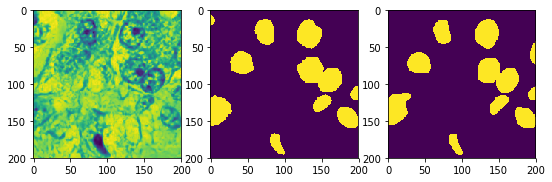

('h185', tensor(0.7781, device='cuda:0'))


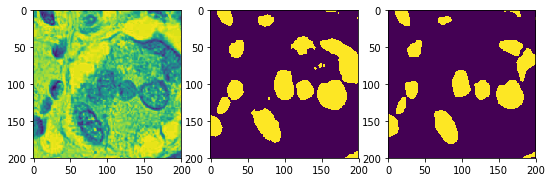

('q416', tensor(0.7919, device='cuda:0'))


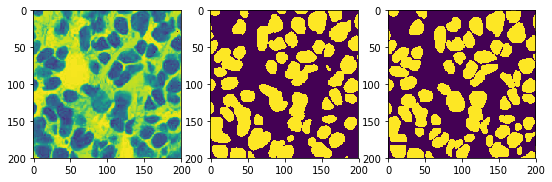

('f138', tensor(0.8000, device='cuda:0'))


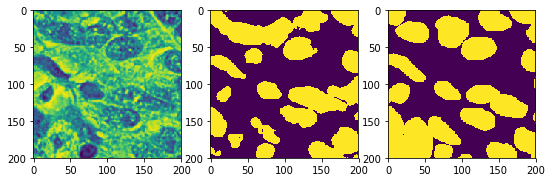

('q405', tensor(0.8311, device='cuda:0'))


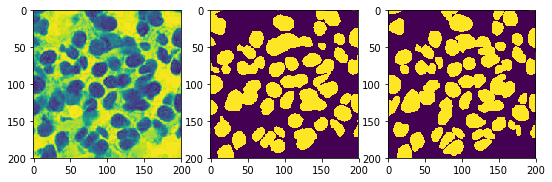

('p388', tensor(0.8292, device='cuda:0'))


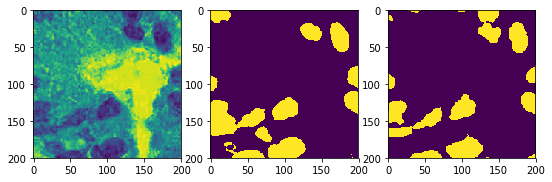

('aa671', tensor(0.8073, device='cuda:0'))


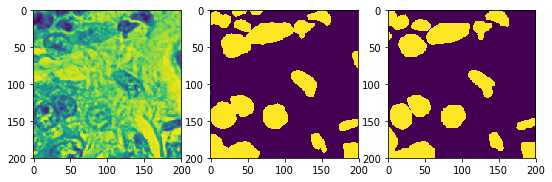

('r448', tensor(0.7576, device='cuda:0'))


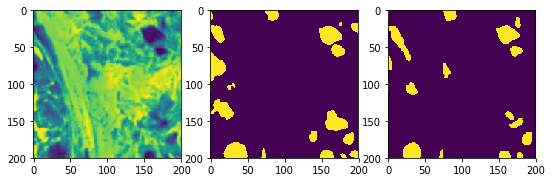

('d86', tensor(0.8130, device='cuda:0'))


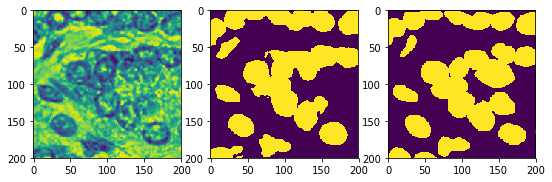

('aabbccddee671', tensor(0.7906, device='cuda:0'))


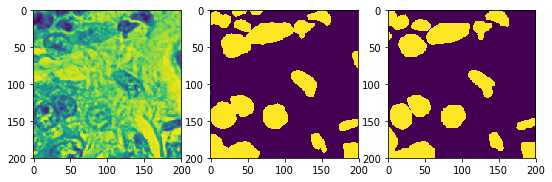

('j247', tensor(0.7466, device='cuda:0'))


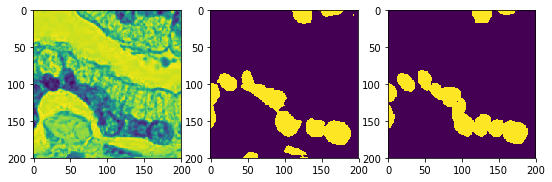

('h179', tensor(0.7855, device='cuda:0'))


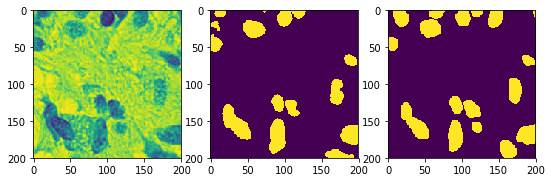

('u520', tensor(0.8242, device='cuda:0'))


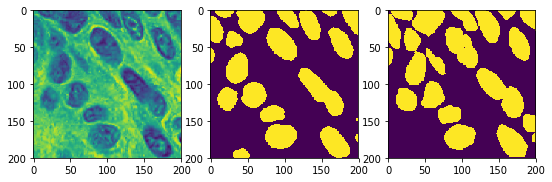

('q417', tensor(0.8344, device='cuda:0'))


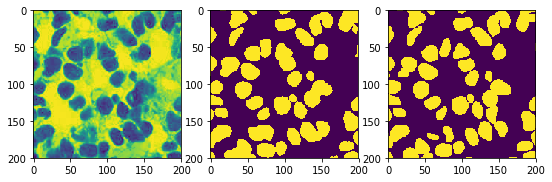

In [48]:
val_vis=DataLoader(EvalDataset('val'),1,shuffle=True, num_workers=2) 
val_vis=val_loader

with torch.set_grad_enabled(False):    
    for idx, batch_data in enumerate(val_vis):
        name=batch_data['name']
        input = Variable(batch_data['image'].float()).cuda()
        dice_mask = Variable(batch_data['mask'].float()).cuda()
        ce_tar=Variable(batch_data['mask2']).cuda()

        pred_mask = model(input)

        pred_mask = model(input)

        ce = loss_fn(pred_mask, ce_tar.long())
        soft_mask=soft_max(pred_mask)
    #                 dice=dice_loss_classes(soft_mask, batch_gt_mask)

        a,b=dice_loss_classes(soft_mask, dice_mask)
        plt.figure(figsize=(9,9))
        plt.subplot(1,3,1)
        plt.imshow(input[0].transpose(0,1).transpose(2,1).cpu().detach()[:,:,0] )

        arg=torch.argmax(soft_mask,1)
        plt.subplot(1,3,2)
        plt.imshow(arg[0].cpu().detach())
        plt.subplot(1,3,3)
        print(name[0],1-b)
        plt.imshow(ce_tar[0].cpu().detach())
        plt.show()

#                 print('Dice Losses: ',a.item(),b.item())
                
                